In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, f1_score

## 1. Data Loading

In [0]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download=True, transform = transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|█████████▉| 170491904/170498071 [00:21<00:00, 8127315.36it/s]

In [0]:
classes = {0:'plane',1:'car',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [0]:
## loading the data from the dataset object
trainloader = torch.utils.data.DataLoader(trainset, batch_size =10, shuffle=True) # batch-size = no. of images 

In [0]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

print(images.shape)  # total of 4 images of size 32 X 32 X 3
print(labels)

print(images[0].shape)
print(labels[0])

torch.Size([10, 3, 32, 32])
tensor([8, 5, 5, 8, 5, 3, 7, 3, 5, 8])
torch.Size([3, 32, 32])
tensor(8)


## 2. Visualize the images

In [0]:
img = images[0]
img = img.numpy()
print(img.shape)
img = np.transpose(img,(1,2,0))
print('transposed: ',img.shape)


(3, 32, 32)
transposed:  (32, 32, 3)


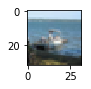

The image is of a ship


In [0]:
plt.figure(figsize=(1,1))
plt.imshow(img)
plt.show()
print('The image is of a',classes[labels[0].item()])

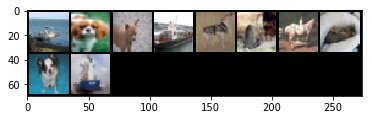

['ship', 'dog', 'dog', 'ship', 'dog', 'cat', 'horse', 'cat', 'dog', 'ship']


In [0]:
def imshow(image):
  img = np.transpose(image.numpy(),(1,2,0))
  plt.imshow(img)
  plt.show()

imshow(torchvision.utils.make_grid(images))  
print([classes[x] for x in labels.numpy()])

## 3. Single Convolution Layer


**Why Convolutional Neural Networks**

The main structural feature of RegularNets is that all the neurons are connected to each other. For example, when we have images with 28 by 28 pixels with only greyscale, we will end up having 784 (28 x 28 x 1) neurons in a layer which seems manageable. However, most images have way more pixels and they are not grey-scaled. Therefore, assuming that we have a set of color images in 4K Ultra HD, we will have 26,542,080 (4096 x 2160 x 3) different neurons connected to each other in the first layer which is not really manageable. Therefore, we can say that RegularNets are not scalable for image classification. However, especially when it comes to images, there seems to be little correlation or relation between two individual pixels unless they are close to each other. This leads to the idea of Convolutional Layers and Pooling Layers.

In [0]:
import torch.nn as nn

class FirstCNN(nn.Module):
  
  def __init__(self):
    super(FirstCNN, self).__init__()
    
    # Convolution operation no. 1
    self.conv1 = nn.Conv2d(3,16,3, padding = (1,1), stride=(2,2)) ## RGB=3, K_filters= 16, Kernel_size=3 # padding = (1,1) and striding = (2,2)
    
  def forward(self,x):
    x = self.conv1(x)
    return x

In [0]:
net = FirstCNN()
out = net(images)
out.shape

torch.Size([10, 16, 16, 16])

In [0]:
for param in net.parameters():
  print(param.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])


16,3,(3,3) = 16 filters, 3 RGB channels and (3,3) kernels - These are the **weight parametes** with
16 bias terms

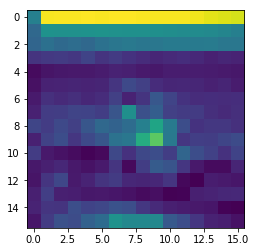

In [0]:
# visualizing one of the hidden layer filter
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

**Note:** RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

## 4. Deep Convolution Network

In [0]:
class FirstCNN_v2(nn.Module):
  
  def __init__(self):
    super(FirstCNN_v2,self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(3,8,3),  # (10,3,32,32) -> (10,8,30,30)
      nn.Conv2d(8,16,3)  # (10,8,30,30) -> (10,16,28,28)
    )
    
  def forward(self,x):
    x = self.model(x)
    return x

In [0]:
model2 = FirstCNN_v2()
out = model2.forward(images)
out.shape

torch.Size([10, 16, 28, 28])

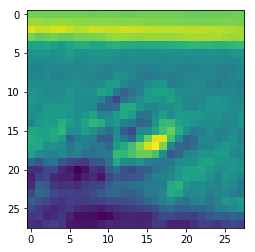

In [0]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

In [0]:
class FirstCNN_v2(nn.Module):
  
  def __init__(self):
    super(FirstCNN_v2,self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(3,6,5),  # (10,3,32,32) -> (10,6,28,28)
      nn.AvgPool2d(2, stride=2), # (10,6,28,28) -> (N,6,14,14) # batch size= 2,2
      nn.Conv2d(6,16,5),  # (N,6,14,14) -> (N,16,10,10)
      nn.AvgPool2d(2, stride=2) # (N,16,10,10) -> (N,16,5,5)
    )
    
  def forward(self,x):
    x = self.model(x)
    return x

In [0]:
model3 = FirstCNN_v2()
out = model3.forward(images)
out.shape

torch.Size([10, 16, 5, 5])

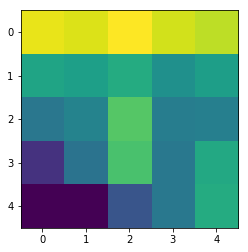

In [0]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

## 5. LeNet

In [0]:
class LeNet(nn.Module):
  
  def __init__(self):
    super(LeNet,self).__init__()
    
    self.cnn_model = nn.Sequential(
        nn.Conv2d(3,6,5), # (N,3,32,32) -> (N,6,28,28)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2), # (N,6,28,28) -> (N,6,14,14)
        nn.Conv2d(6,16,5), # (N,6,14,14) -> (N,16,10,10)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2) # (N,16,10,10) -> (N,16,5,5)    
    )

    # Note: here for output there is no softmax function
    self.fc_model = nn.Sequential(
        nn.Linear(400,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,10)
    )
  
  def forward(self,x):
    print(x.shape)
    x = self.cnn_model(x)
    print(x.shape)
    x = x.view(x.size(0),-1) # reshaping the cnn output to 2d matrix for nn propagation
    print(x.shape)
    x = self.fc_model(x)
    print(x.shape)
    return x

**Note**: Inference part doesnot have softmax part but when learning from the loss function the softmax function is implemented

In [0]:
model4 = LeNet()
out = model4(images)
print('The final output shape is:',out.shape)

torch.Size([10, 3, 32, 32])
torch.Size([10, 16, 5, 5])
torch.Size([10, 400])
torch.Size([10, 10])
The final output shape is: torch.Size([10, 10])


## 6. Training LeNet

### 6.1 Preparing the data

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download=True, transform = transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128, shuffle=True) # batch-size = no. of images 

Files already downloaded and verified


In [0]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

In [0]:
device = torch.device('cuda')

In [0]:
X = images.to(device)
Y = labels.to(device)
print(X.size())

torch.Size([128, 3, 32, 32])


### 6.2 Modelling

In [0]:
class LeNet_1(nn.Module):
  
  def __init__(self):
    super(LeNet_1,self).__init__()
    
    self.cnn_model = nn.Sequential(
        nn.Conv2d(3,6,5), # (N,3,32,32) -> (N,6,28,28)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2), # (N,6,28,28) -> (N,6,14,14)
        nn.Conv2d(6,16,5), # (N,6,14,14) -> (N,16,10,10)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2) # (N,16,10,10) -> (N,16,5,5)    
    )

    # Note: here for output there is no softmax function
    self.fc_model = nn.Sequential(
        nn.Linear(400,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,10)
    )
  
  def forward(self,x):
    x = self.cnn_model(x)
    x = x.view(x.size(0),-1) # reshaping the cnn output to 2d matrix for nn propagation
    x = self.fc_model(x)
    return x

In [0]:
def fit(X,Y,model,opt,loss_fn,epochs=100):
  
  loss_arr = []
  
  for i in range(epochs):
    loss = loss_fn(model(X),Y)
    loss_arr.append(loss)
    loss.backward()
    opt.step()
    opt.zero_grad()
  return loss_arr    

In [0]:
model5 = LeNet_1()
model5.to(device)
loss_fn = nn.CrossEntropyLoss()
loss_fn(model5(X),Y)

tensor(2.3099, device='cuda:0', grad_fn=<NllLossBackward>)

torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])
torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
to

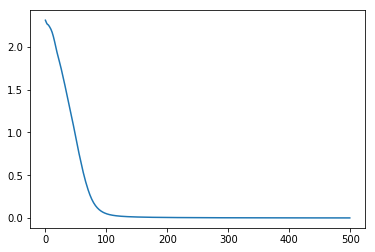

In [0]:
model5 = LeNet()
model5 = model5.to(device)
opt = optim.Adam(model5.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

loss_arr = fit(X,Y,model5,opt,loss_fn,epochs=500)
plt.plot(loss_arr)
plt.show()

In [0]:
def accuracy(Y_true,Y_pred):
  return torch.sum(Y_true==torch.argmax(Y_pred,dim=1)).item()/len(Y_true)*100

accuracy(Y,model5(X))

torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])


100.0

### 6.3 Evaluation on test data set

In [0]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified


In [0]:
test_data_iter = iter(testloader)
test_images,test_labels = test_data_iter.next()

# convert the tensors to GPU tensors
X_test = test_images.to(device)
Y_test = test_labels.to(device)

In [0]:
accuracy(Y_test,model5(X_test))

torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])


17.96875

tensor([7, 4, 6, 8, 7, 4, 8, 4, 3, 4, 8, 7, 3, 8, 7, 9, 5, 3, 7, 6, 9, 1, 6, 8,
        3, 0, 8, 3, 7, 2, 7, 9, 6, 2, 7, 9, 9, 0, 9, 6, 9, 9, 5, 8, 2, 3, 1, 5,
        5, 3, 2, 2, 5, 4, 1, 8, 4, 1, 9, 1, 1, 3, 6, 6, 4, 3, 6, 9, 0, 4, 6, 1,
        5, 3, 5, 4, 8, 6, 3, 4, 4, 4, 1, 1, 1, 8, 3, 6, 0, 8, 3, 3, 4, 2, 5, 7,
        0, 2, 5, 5, 9, 8, 0, 0, 4, 3, 3, 2, 2, 8, 3, 4, 9, 1, 4, 5, 4, 4, 9, 7,
        9, 6, 2, 7, 0, 1, 0, 9], device='cuda:0')